## Pretrained GAN

In [33]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [34]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

## Crappified data

Prepare the input data by crappifying images.

In [35]:
from crappify import *

Uncomment the first time you run this notebook.

In [39]:
il = ImageList.from_folder(path_hr)

def my_crappify(fn):
    img = PIL.Image.open(fn)
    w,h = img.size
    shape = [random.randint(0,w//2),random.randint(0,h//2), random.randint(0,w//2), random.randint(0,h//2)]
    ImageDraw.Draw(img).line(shape, fill=(255,255,255), width=random.randint(1, 4))
    img.show()

my_crappify(il.items[0])
#il.items[0].name

'staffordshire_bull_terrier_85.jpg'

In [36]:
il = ImageList.from_folder(path_hr)
parallel(crappifier(path_lr, path_hr), il.items)

For gradual resizing we can change the commented line here.

In [37]:
bs,size=32, 128
# bs,size = 24,160
#bs,size = 8,256
arch = models.resnet34

## Pre-train generator

Now let's pretrain the generator.

In [48]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [49]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=1), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [50]:
data_gen = get_data(bs,size)

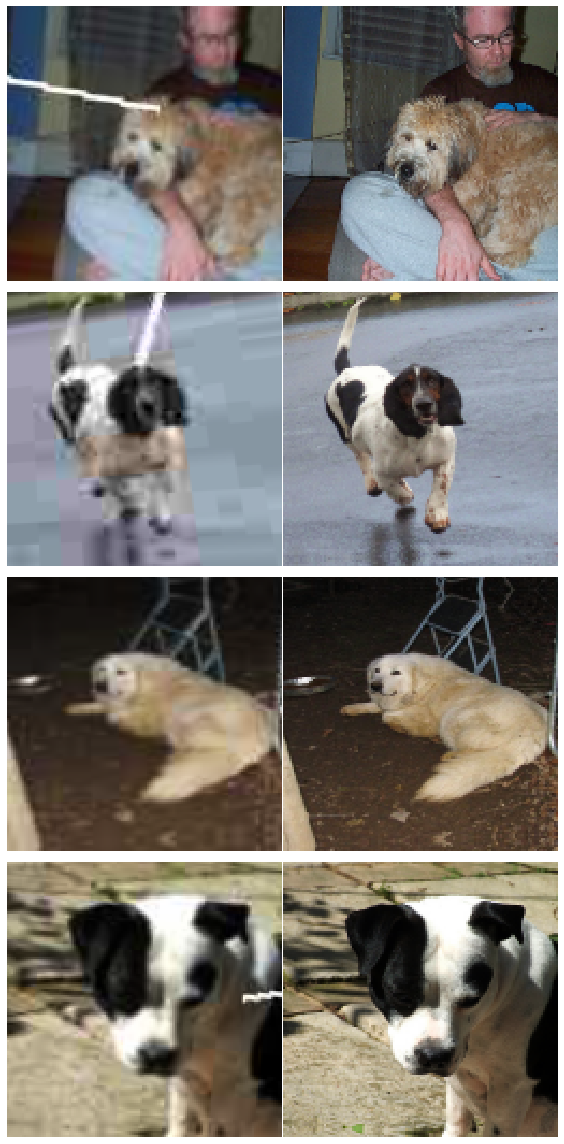

In [51]:
data_gen.show_batch(4)

In [52]:
wd = 1e-3

In [53]:
y_range = (-3.,3.)

In [54]:
loss_gen = MSELossFlat()

In [55]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [58]:
learn_gen=None
gc.collect()
learn_gen = create_gen_learner()

In [59]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

In [60]:
learn_gen.unfreeze()

In [61]:
learn_gen.fit_one_cycle(5, slice(1e-6,1e-3))

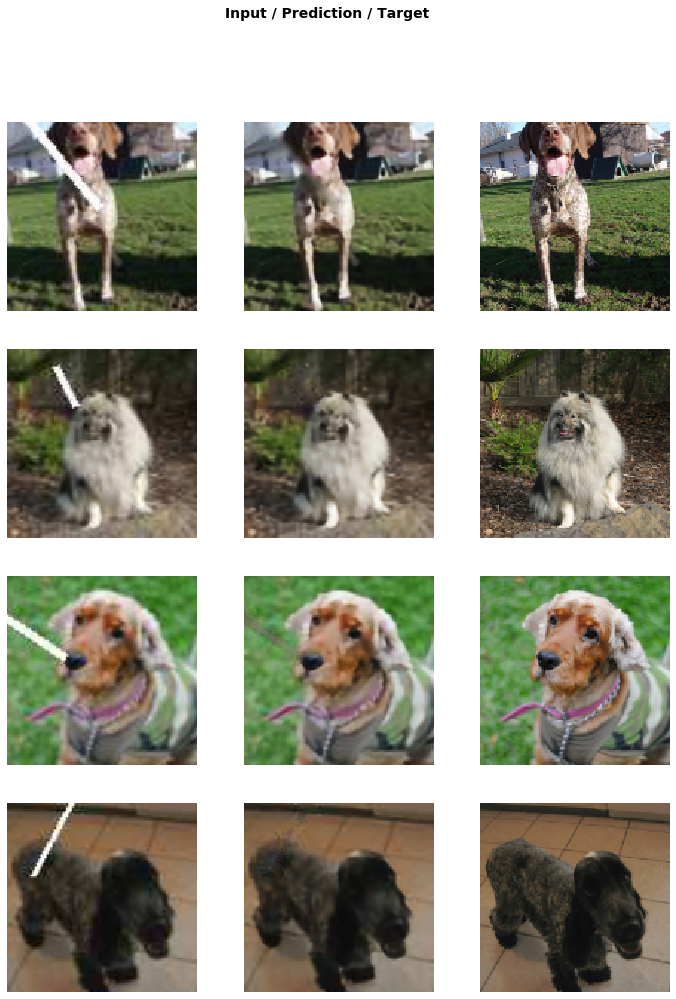

In [62]:
learn_gen.show_results(rows=4)

In [64]:
learn_gen.save('gen-pre2')

## Save generated images

In [65]:
learn_gen.load('gen-pre2');

In [66]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [ ]:
# shutil.rmtree(path_gen)

In [67]:
path_gen.mkdir(exist_ok=True)

In [68]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [69]:
save_preds(data_gen.fix_dl)

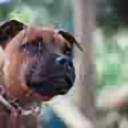

In [70]:
PIL.Image.open(path_gen.ls()[0])

## Train critic

In [71]:
learn_gen=None
gc.collect()

35

Pretrain the critic on crappy vs not crappy.

In [72]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [75]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

In [77]:
data_crit.classes

['image_gen', 'images']

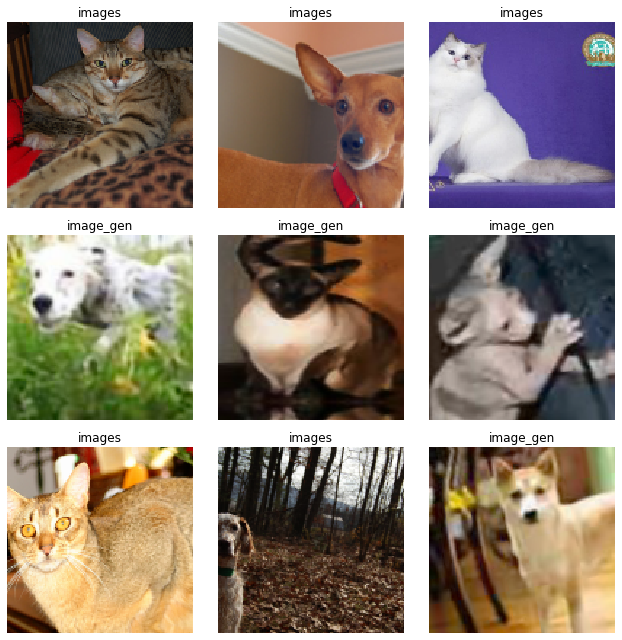

In [78]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [79]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [80]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [81]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [82]:
learn_critic.fit_one_cycle(6, 1e-3)

In [85]:
learn_critic.save('critic-pre2')

## GAN

Now we'll combine those pretrained model in a GAN.

In [89]:
learn_crit=None
learn_gen=None
gc.collect()

1372

In [90]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)

In [91]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

In [92]:
learn_gen = create_gen_learner().load('gen-pre2')

To define a GAN Learner, we just have to specify the learner objects foor the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0). 

The loss of the generator is weighted sum (weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the `learn_gen.loss_func` applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [93]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [94]:
lr = 1e-4

In [95]:
learn.fit(40,lr)

In [96]:
learn.save('gan-1c')

In [99]:
learn.data=get_data(16,192)

In [ ]:
learn.fit(10,lr/2)

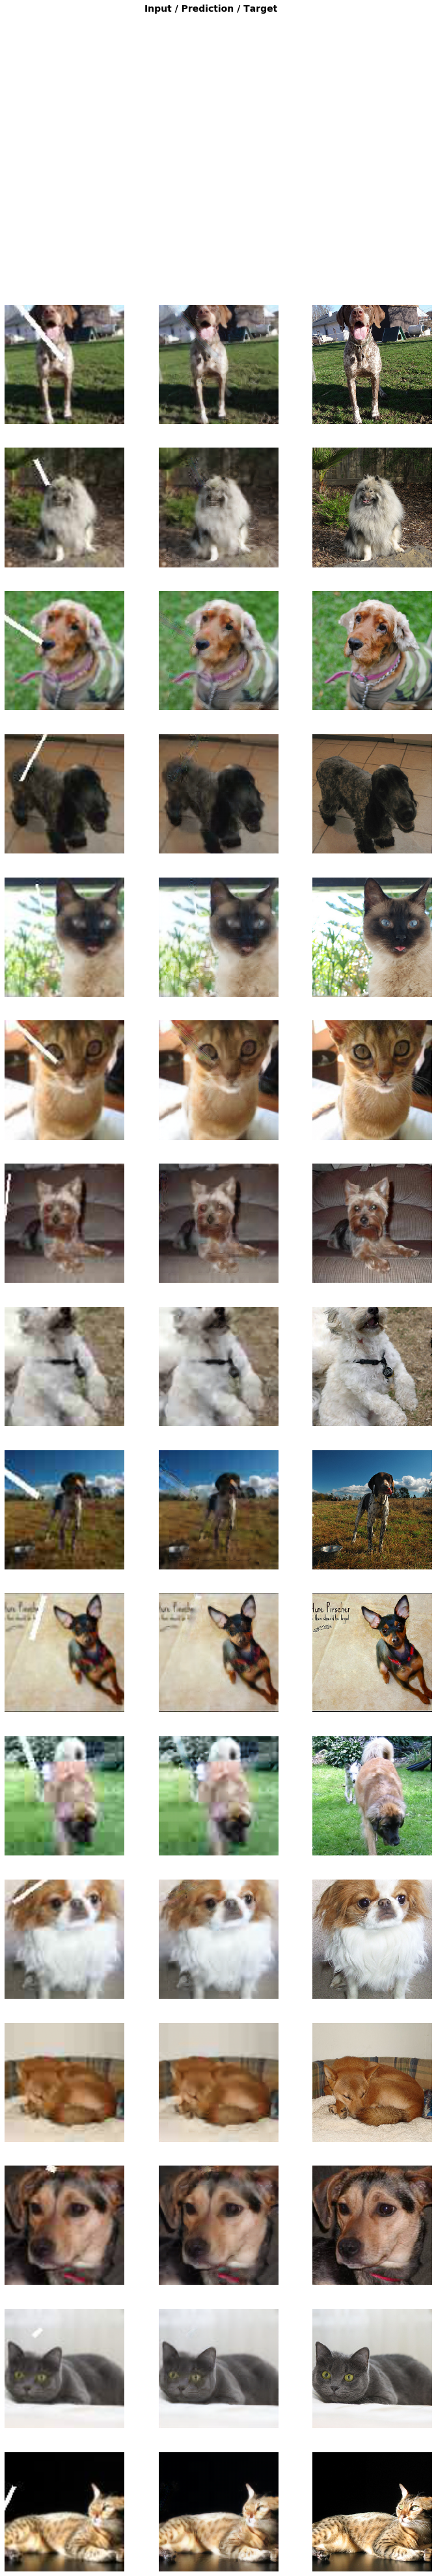

In [98]:
learn.show_results(rows=16)

In [ ]:
learn.save('gan-1c')

## fin